<h1 style="text-align: center;color:#82cc1a">Hybrid Anime Recommendation System</h1>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict

import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set(style='whitegrid', context='talk')

SEED = 11
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 11


<h1 style="text-align: center;color:#647b389">Reading Data</h1>

In [3]:
RAW_DIR = os.path.join("..", "artifacts/raw")

anime_df = pd.read_csv(RAW_DIR+"/anime.csv", low_memory=True)
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [4]:
anime_df.describe()


,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


In [5]:
rating_df = pd.read_csv(RAW_DIR+"/animelist.csv", low_memory=True)
rating_df.info()
rating_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 228.9 MB


,user_id,anime_id,rating,watching_status,watched_episodes
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,9.960794e+03,1.655395e+04,4.289415e+00,3.079064e+00,1.230280e+01
std,5.659825e+03,1.379685e+04,3.907219e+00,1.770329e+00,1.737191e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.199000e+03,3.269000e+03,0.000000e+00,2.000000e+00,0.000000e+00
50%,1.013600e+04,1.253100e+04,6.000000e+00,2.000000e+00,3.000000e+00
75%,1.480200e+04,3.090100e+04,8.000000e+00,6.000000e+00,1.200000e+01
max,1.968200e+04,4.849100e+04,1.000000e+01,6.000000e+00,6.553500e+04


In [6]:
rating_df.sample(8)

,user_id,anime_id,rating,watching_status,watched_episodes
1226342,4183,11319,6,2,12
2287783,7691,1530,0,6,0
1096356,3715,6553,7,2,1
1250499,4294,18153,9,2,12
2385497,8000,1210,9,2,24
3699486,12256,7044,8,2,2
3934064,12994,7148,7,2,12
4511951,14851,18857,2,2,3


<h1 style="text-align: center;color:#647b389">Data Processing</h1>

In [7]:
#### Check Duplicates
print(f"rating_df has {rating_df.duplicated().sum()} duplicates")
print(f"anime_df has {anime_df.duplicated().sum()} duplicates")

rating_df has 0 duplicates
anime_df has 0 duplicates


In [8]:
### check for missing values
print(f"rating_df has {rating_df.isnull().sum().sum()} missing values")
print(f"anime_df has {anime_df.isnull().sum().sum()} missing values")

rating_df has 0 missing values
anime_df has 0 missing values


In [9]:
ratings_cnt = rating_df['rating'].value_counts()
print(f"Rating counts:\n{ratings_cnt}")
print("===="*10)
print(f"Rating dist: {rating_df['rating'].describe()}")

Rating counts:
rating
0     2536655
8      857524
7      791908
9      570117
6      417415
10     392277
5      224832
4      103060
3       50741
2       30534
1       24937
Name: count, dtype: int64
Rating dist: count    6.000000e+06
mean     4.289415e+00
std      3.907219e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64


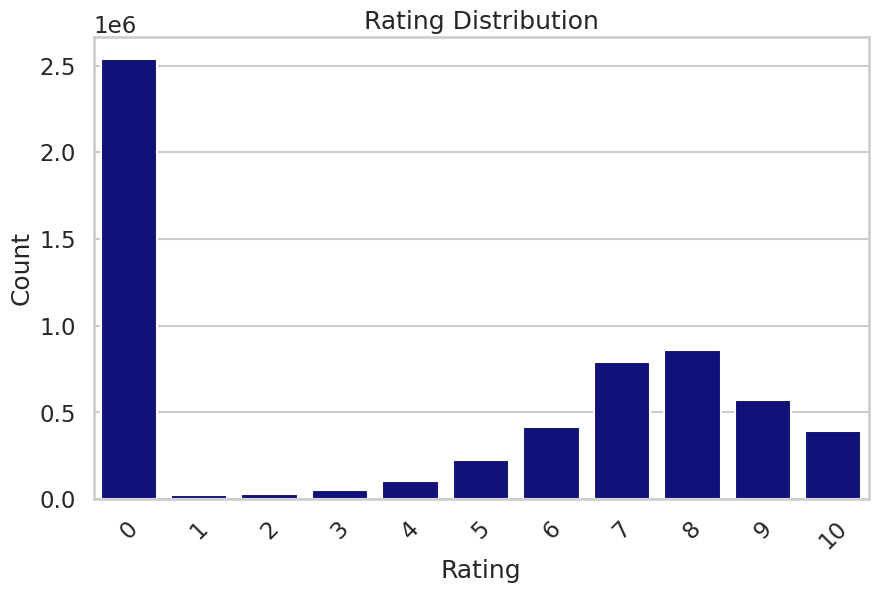

In [10]:

plt.figure(figsize=(10, 6))
sns.countplot(data=rating_df, x='rating', order=range(11), color='darkblue')
## Else use order = rating_cnt.index to get the order from the counts
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show();

Scaling the ratings data to a range of 0 to 1:

In [11]:
ratings_cnt.index

Index([0, 8, 7, 9, 6, 10, 5, 4, 3, 2, 1], dtype='int64', name='rating')

In [14]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])

rating_df['rating'] = rating_df['rating'].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float16)

In [13]:
rating_df['rating'].describe()

count    6.000000e+06
mean              NaN
std      0.000000e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000977e-01
75%      7.998047e-01
max      1.000000e+00
Name: rating, dtype: float64

Someone who has rated over 300 anine titles is likely to be a serious anime fan. We will use this as a threshold to filter our dataset.

In [15]:
NUM_REVIEW_THRESHOLD = 300

n_ratings = rating_df['user_id'].value_counts()
# print(f"Rating per user (Before cleaing):\n{n_ratings}")
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= NUM_REVIEW_THRESHOLD].index)]
n_ratings = rating_df['user_id'].value_counts()
# print(f"Rating per user (After cleaing):\n{rating_df['user_id'].value_counts()}")

In [16]:
n_ratings

user_id
11100    14429
16869     8943
10255     8403
4773      5735
6852      5406
         ...  
12115      300
11958      300
13963      300
7311       300
7758       300
Name: count, Length: 7013, dtype: int64

In [21]:
rating_df

,user_id,anime_id,rating,watching_status,watched_episodes
213,2,24833,0.0,1,0
214,2,235,1.0,1,100
215,2,36721,0.0,1,1
216,2,40956,0.0,1,0
217,2,31933,0.0,1,3
...,...,...,...,...,...
5999247,19675,3974,0.0,6,0
5999248,19675,4654,0.0,6,0
5999249,19675,4896,0.0,6,0
5999250,19675,3322,0.0,6,0


#### UserID and AnimeID encoding and decoding

In [22]:
### USer to ID mapping
user_ids = rating_df['user_id'].unique().tolist()
userId_2_encodedUserId_mapping = {x:i for (i,x) in enumerate(user_ids)}
encodedUserId_2_userId_mapping = {i:x for (i,x) in enumerate(user_ids)}

In [23]:
for i in range(10):
    print(f"org userID:{encodedUserId_2_userId_mapping[i]}  ||  encoded ID:{userId_2_encodedUserId_mapping[encodedUserId_2_userId_mapping[i]]}")

org userID:2  ||  encoded ID:0
org userID:3  ||  encoded ID:1
org userID:6  ||  encoded ID:2
org userID:12  ||  encoded ID:3
org userID:16  ||  encoded ID:4
org userID:17  ||  encoded ID:5
org userID:19  ||  encoded ID:6
org userID:21  ||  encoded ID:7
org userID:34  ||  encoded ID:8
org userID:41  ||  encoded ID:9


In [24]:
rating_df['encoded_userID'] = rating_df['user_id'].map(userId_2_encodedUserId_mapping)
rating_df[['user_id', 'encoded_userID']].sample(7)

,user_id,encoded_userID
2391741,8022,2824
5828023,19125,6805
3546254,11746,4110
839933,2844,976
3188650,10682,3714
1147354,3911,1350
1970851,6715,2340


In [25]:
n_users = len(userId_2_encodedUserId_mapping)
print(f"Total number of users (with >= {NUM_REVIEW_THRESHOLD} reviews): {n_users}")

Total number of users (with >= 300 reviews): 7013


In [26]:
### Anime ID encoding
anime_ids = rating_df['anime_id'].unique().tolist()
animeId_2_encodedAnimeId_mapping = {x:i for (i,x) in enumerate(anime_ids)}
encodedAnimeId_2_animeId_mapping = {i:x for (i,x) in enumerate(anime_ids)}

for i in range(10):
    print(f"org animeID:{encodedAnimeId_2_animeId_mapping[i]}  ||  encoded ID:{animeId_2_encodedAnimeId_mapping[encodedAnimeId_2_animeId_mapping[i]]}")

org animeID:24833  ||  encoded ID:0
org animeID:235  ||  encoded ID:1
org animeID:36721  ||  encoded ID:2
org animeID:40956  ||  encoded ID:3
org animeID:31933  ||  encoded ID:4
org animeID:5042  ||  encoded ID:5
org animeID:7593  ||  encoded ID:6
org animeID:21  ||  encoded ID:7
org animeID:35446  ||  encoded ID:8
org animeID:24  ||  encoded ID:9


In [27]:
rating_df['encoded_animeID'] = rating_df['anime_id'].map(animeId_2_encodedAnimeId_mapping)
rating_df[['anime_id', 'encoded_animeID']].sample(7)

,anime_id,encoded_animeID
639321,19383,4377
348528,31859,178
4533191,30544,1387
4597459,34984,3514
5129409,1972,949
2015772,40713,14503
3345533,9107,2059


In [28]:
n_animes = len(animeId_2_encodedAnimeId_mapping)
print(f"Total number of animes: {n_animes}")

Total number of animes: 17200


#### Random shuffling of the dataset

In [29]:
rating_df = rating_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

#### Splitting the dataset into training and testing sets

In [30]:
X = rating_df[['encoded_userID', 'encoded_animeID']].values
y = rating_df['rating'].values

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (4583100, 2), y shape: (4583100,)


In [31]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.005
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (4560184, 2), Y_train shape: (4560184,)
X_test shape: (22916, 2), Y_test shape: (22916,)


In [32]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
### First column is Encoded_userID, second column is Encoded_animeID
X_test_array = [X_test[:, 0], X_test[:, 1]]

print(f"X_train_array[0] shape: {X_train_array[0].shape}, X_train_array[1] shape: {X_train_array[1].shape}")
print(f"X_test_array[0] shape: {X_test_array[0].shape}, X_test_array[1] shape: {X_test_array[1].shape}")

X_train_array[0] shape: (4560184,), X_train_array[1] shape: (4560184,)
X_test_array[0] shape: (22916,), X_test_array[1] shape: (22916,)


In [33]:
X_test_array

[array([4113, 4441, 3288, ..., 1477,  130, 1360]),
 array([ 353, 1676, 1366, ..., 1393, 4427, 1010])]

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau



2025-05-27 17:54:40.241889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 17:54:40.408314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748348680.495934   25026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748348680.519306   25026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 17:54:40.674094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [27]:
def RecommendNet():
    EMBEDDING_SIZE = 128
    user = Input(name='user_input', shape=[1])
    user_embedding = Embedding(input_dim=n_users, output_dim=EMBEDDING_SIZE, name='user_embedding')(user)
    anime = Input(name='anime_input', shape=[1])
    anime_embedding = Embedding(input_dim=n_animes, output_dim=EMBEDDING_SIZE, name='anime_embedding')(anime)

    x = Dot(axes=2, normalize=True)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dropout(0.2)(x)
    model = Model(inputs=[user, anime], outputs=x)  
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model


<h1 style="text-align: center;color:#647b389">Model Training</h1>

In [34]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 1024
NUM_EPOCHS = 10

In [35]:
user_ids_train = torch.tensor(X_train[:, 0], dtype=torch.long)
anime_ids_train = torch.tensor(X_train[:, 1], dtype=torch.long)
ratings_train = torch.tensor(Y_train, dtype=torch.float)

user_ids_test = torch.tensor(X_test[:, 0], dtype=torch.long)
anime_ids_test = torch.tensor(X_test[:, 1], dtype=torch.long)
ratings_test = torch.tensor(Y_test, dtype=torch.float)

In [40]:
print(len(ratings_train.shape))

2


In [37]:
if len(ratings_train.shape) == 1:
    ratings_train = ratings_train.unsqueeze(1)  # Shape: (num_samples, 1)
if len(ratings_test.shape) == 1:
    ratings_test = ratings_test.unsqueeze(1)

In [43]:
n_users, n_animes = len(userId_2_encodedUserId_mapping), len(animeId_2_encodedAnimeId_mapping)
print(f"Number of users: {n_users}, Number of animes: {n_animes}")

Number of users: 7013, Number of animes: 17200


In [33]:
class RecommenderNet(nn.Module):
    def __init__(self, EMBEDDING_SIZE=128, N_USERS=7013, N_ANIMES=17200):
        super().__init__()

        self.embedding_dim = EMBEDDING_SIZE
        self.n_users = N_USERS
        self.n_animes = N_ANIMES
        
        # Remove the trailing commas
        self.user_emb_layer = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.embedding_dim)
        self.anime_emb_layer = nn.Embedding(num_embeddings=self.n_animes, embedding_dim=self.embedding_dim)

        self.dense1 = nn.Linear(in_features=1, out_features=1)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)

    def forward(self, user, anime):
        # user: tensor of shape (batch_size,)
        # anime: tensor of shape (batch_size,)

        # Get embeddings
        user_emb = self.user_emb_layer(user)  # Shape: (batch_size, embedding_size)
        anime_emb = self.anime_emb_layer(anime)  # Shape: (batch_size, embedding_size)

        # Normalize embeddings (L2 norm)
        user_emb_norm = user_emb / torch.norm(user_emb, dim=1, keepdim=True)
        anime_emb_norm = anime_emb / torch.norm(anime_emb, dim=1, keepdim=True)

        # Compute cosine similarity (DOT proD)
        x = torch.sum(user_emb_norm * anime_emb_norm, dim=1, keepdim=True)  # Shape (BS, 1)

        x = self.dense1(x)  # Shape (BS, 1)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        return x

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_users = len(userId_2_encodedUserId_mapping)
n_animes = len(animeId_2_encodedAnimeId_mapping)
model = RecommenderNet(EMBEDDING_SIZE=128, N_USERS=n_users, N_ANIMES=n_animes).to(DEVICE)
summary(model, input_size=[(1,), (1,)], dtypes=[torch.long, torch.long], col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
RecommenderNet                           [1]                       [1, 1]                    --                        True
├─Embedding: 1-1                         [1]                       [1, 128]                  897,664                   True
├─Embedding: 1-2                         [1]                       [1, 128]                  2,201,600                 True
├─Linear: 1-3                            [1, 1]                    [1, 1]                    2                         True
├─BatchNorm1d: 1-4                       [1, 1]                    [1, 1]                    2                         True
├─ReLU: 1-5                              [1, 1]                    [1, 1]                    --                        --
├─Dropout: 1-6                           [1, 1]                    [1, 1]                    --                        --
Total p

#### DAtaLoader and Dataset

In [34]:
train_dataset = TensorDataset(user_ids_train, anime_ids_train, ratings_train)
test_dataset = TensorDataset(user_ids_test, anime_ids_test, ratings_test)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
def train_rec_net(model, train_loader, test_loader, num_epochs=25, lr=1e-3, device='cuda'):
    model.train()
    model.to(device)

    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    metrics = {
        'train_losses': [],
        'train_maes': [],
        'val_losses': [],
        'val_maes': []
    }

    for epoch in tqdm(range(num_epochs), colour='green', desc='Epoch'):
        model.train()
        total_train_loss = 0.0
        total_train_mae = 0.0
        num_train_batches = 0

        for user, anime, rating in train_loader:
            user = user.to(device)
            anime = anime.to(device)
            rating = rating.to(device).float()

            optimizer.zero_grad()
            predictions = model(user, anime)
            loss = criterion(predictions, rating)
            mae = torch.mean(torch.abs(predictions - rating))

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_mae += mae.item()
            num_train_batches += 1

        avg_train_loss = total_train_loss / num_train_batches
        avg_train_mae = total_train_mae / num_train_batches
        metrics['train_losses'].append(avg_train_loss)
        metrics['train_maes'].append(avg_train_mae)

        model.eval()
        total_val_loss = 0.0
        total_val_mae = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for user, anime, rating in test_loader:
                user = user.to(device)
                anime = anime.to(device)
                rating = rating.to(device).float()

                predictions = model(user, anime)
                loss = criterion(predictions, rating)
                mae = torch.mean(torch.abs(predictions - rating))

                total_val_loss += loss.item()
                total_val_mae += mae.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        avg_val_mae = total_val_mae / num_val_batches
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_maes'].append(avg_val_mae)

        tqdm.write(f"Epoch {epoch+1}/{num_epochs} | "
                   f"Train Loss: {avg_train_loss:.4f} | Train MAE: {avg_train_mae:.4f} | "
                   f"Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")

    return metrics

In [72]:
metrics = train_rec_net(model, train_loader, test_loader, num_epochs=NUM_EPOCHS, lr=1e-3, device=DEVICE)

Epoch:   5%|▌         | 1/20 [00:37<11:45, 37.12s/it]

Epoch 1/20 | Train Loss: 0.1064 | Train MAE: 0.2087 | Val Loss: 0.0907 | Val MAE: 0.2273


Epoch:  10%|█         | 2/20 [01:17<11:45, 39.19s/it]

Epoch 2/20 | Train Loss: 0.1051 | Train MAE: 0.2064 | Val Loss: 0.0960 | Val MAE: 0.2341


Epoch:  15%|█▌        | 3/20 [02:04<12:03, 42.56s/it]

Epoch 3/20 | Train Loss: 0.1041 | Train MAE: 0.2045 | Val Loss: 0.0993 | Val MAE: 0.2373


Epoch:  20%|██        | 4/20 [02:51<11:47, 44.19s/it]

Epoch 4/20 | Train Loss: 0.1034 | Train MAE: 0.2030 | Val Loss: 0.0941 | Val MAE: 0.2305


Epoch:  25%|██▌       | 5/20 [03:36<11:09, 44.62s/it]

Epoch 5/20 | Train Loss: 0.1026 | Train MAE: 0.2014 | Val Loss: 0.0977 | Val MAE: 0.2350


Epoch:  30%|███       | 6/20 [04:24<10:40, 45.75s/it]

Epoch 6/20 | Train Loss: 0.1018 | Train MAE: 0.1999 | Val Loss: 0.0977 | Val MAE: 0.2331


Epoch:  35%|███▌      | 7/20 [05:11<09:58, 46.06s/it]

Epoch 7/20 | Train Loss: 0.1009 | Train MAE: 0.1983 | Val Loss: 0.0954 | Val MAE: 0.2284


Epoch:  40%|████      | 8/20 [05:50<08:48, 44.00s/it]

Epoch 8/20 | Train Loss: 0.1005 | Train MAE: 0.1972 | Val Loss: 0.0973 | Val MAE: 0.2337


Epoch:  45%|████▌     | 9/20 [06:34<08:02, 43.84s/it]

Epoch 9/20 | Train Loss: 0.0999 | Train MAE: 0.1960 | Val Loss: 0.0952 | Val MAE: 0.2287


Epoch:  50%|█████     | 10/20 [07:16<07:13, 43.33s/it]

Epoch 10/20 | Train Loss: 0.0993 | Train MAE: 0.1947 | Val Loss: 0.0969 | Val MAE: 0.2328


Epoch:  55%|█████▌    | 11/20 [07:59<06:29, 43.31s/it]

Epoch 11/20 | Train Loss: 0.0988 | Train MAE: 0.1938 | Val Loss: 0.0949 | Val MAE: 0.2270


Epoch:  60%|██████    | 12/20 [08:42<05:44, 43.07s/it]

Epoch 12/20 | Train Loss: 0.0983 | Train MAE: 0.1927 | Val Loss: 0.0934 | Val MAE: 0.2252


Epoch:  65%|██████▌   | 13/20 [09:27<05:06, 43.80s/it]

Epoch 13/20 | Train Loss: 0.0978 | Train MAE: 0.1916 | Val Loss: 0.0980 | Val MAE: 0.2310


Epoch:  70%|███████   | 14/20 [10:13<04:26, 44.48s/it]

Epoch 14/20 | Train Loss: 0.0975 | Train MAE: 0.1909 | Val Loss: 0.0944 | Val MAE: 0.2263


Epoch:  75%|███████▌  | 15/20 [10:58<03:43, 44.63s/it]

Epoch 15/20 | Train Loss: 0.0971 | Train MAE: 0.1899 | Val Loss: 0.0968 | Val MAE: 0.2290


Epoch:  80%|████████  | 16/20 [11:38<02:53, 43.28s/it]

Epoch 16/20 | Train Loss: 0.0968 | Train MAE: 0.1892 | Val Loss: 0.0980 | Val MAE: 0.2297


Epoch:  85%|████████▌ | 17/20 [12:18<02:06, 42.24s/it]

Epoch 17/20 | Train Loss: 0.0963 | Train MAE: 0.1882 | Val Loss: 0.0969 | Val MAE: 0.2273


Epoch:  90%|█████████ | 18/20 [12:57<01:22, 41.14s/it]

Epoch 18/20 | Train Loss: 0.0961 | Train MAE: 0.1876 | Val Loss: 0.0965 | Val MAE: 0.2264


Epoch:  95%|█████████▌| 19/20 [13:34<00:40, 40.12s/it]

Epoch 19/20 | Train Loss: 0.0957 | Train MAE: 0.1868 | Val Loss: 0.0949 | Val MAE: 0.2252


Epoch: 100%|██████████| 20/20 [14:13<00:00, 42.66s/it]

Epoch 20/20 | Train Loss: 0.0952 | Train MAE: 0.1859 | Val Loss: 0.0963 | Val MAE: 0.2264


In [37]:
# Extract the embedding weights
user_embeddings = model.user_emb_layer.weight.data  # Shape: (n_users, embedding_dim)
anime_embeddings = model.anime_emb_layer.weight.data  # Shape: (n_animes, embedding_dim)

# Normalize the embeddings (L2 normalization, same as in the forward method)
user_embeddings_norm = user_embeddings / (torch.norm(user_embeddings, dim=1, keepdim=True) + 1e-8)
anime_embeddings_norm = anime_embeddings / (torch.norm(anime_embeddings, dim=1, keepdim=True) + 1e-8)

# Convert to NumPy arrays for further use
user_embeddings_norm_np = user_embeddings_norm.cpu().numpy()  # Shape: (7013, 128)
anime_embeddings_norm_np = anime_embeddings_norm.cpu().numpy()  # Shape: (17200, 128)

# Print shapes to confirm
print(f"Normalized user embeddings shape: {user_embeddings_norm_np.shape}")
print(f"Normalized anime embeddings shape: {anime_embeddings_norm_np.shape}")

Normalized user embeddings shape: (7013, 128)
Normalized anime embeddings shape: (17200, 128)


In [38]:
torch.save({
    "user_embeddings": user_embeddings_norm,
    "anime_embeddings": anime_embeddings_norm
}, "normalized_embeddings.pt")

checkpoint = torch.load("normalized_embeddings.pt", map_location='cpu')
user_embeddings = checkpoint["user_embeddings"]
anime_embeddings = checkpoint["anime_embeddings"]

In [39]:
import h5py

with h5py.File("normalized_embeddings.h5", "w") as f:
    f.create_dataset("user_embeddings", data=user_embeddings_norm.cpu().numpy())
    f.create_dataset("anime_embeddings", data=anime_embeddings_norm.cpu().numpy())

# with h5py.File("normalized_embeddings.h5", "r") as f:
#     user_embeddings_loaded = torch.tensor(f["user_embeddings"][:])
#     anime_embeddings_loaded = torch.tensor(f["anime_embeddings"][:])

<h1 style="text-align: center;color:#647b389">Handling `Anime.csv`</h1>

In [101]:
anime_df = pd.read_csv(RAW_DIR+"/anime.csv", low_memory=True)
anime_df.info()
anime_df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,...,Unknown,Unknown,Unknown,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17558,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,...,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17560,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,TV,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [102]:
print(anime_df.isna().sum().sum())
anime_df = anime_df.replace("Unknown", np.nan)


0


In [103]:
def get_anime_name(anime_id): ## org anime id (not the encoded ones from animelist)
    try:
        row = anime_df[anime_df.MAL_ID == anime_id]
        name = row["English name"].values[0]
        if pd.isna(name):
            name = row["Name"].values[0]
        return name
    except:
        print("error while retriving anime name")


In [104]:
cnt=0
for i in range(10):
    x = get_anime_name(i)
    if x is None:
        cnt+=1
    else:
        print(x)
print(cnt)

error while retriving anime name
Cowboy Bebop
error while retriving anime name
error while retriving anime name
error while retriving anime name
Cowboy Bebop:The Movie
Trigun
Witch Hunter Robin
Beet the Vandel Buster
error while retriving anime name
5


In [105]:
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [106]:
anime_df["eng_version"] = anime_df.MAL_ID.apply(lambda x: get_anime_name(x))
print(anime_df["eng_version"].loc[:10])

0                   Cowboy Bebop
1         Cowboy Bebop:The Movie
2                         Trigun
3             Witch Hunter Robin
4         Beet the Vandel Buster
5                   Eyeshield 21
6               Honey and Clover
7     Hungry Heart: Wild Striker
8         Initial D Fourth Stage
9                        Monster
10                        Naruto
Name: eng_version, dtype: object


In [44]:
anime_df["eng_version"] = anime_df.MAL_ID.apply(lambda x: get_anime_name(x))
print(anime_df["eng_version"].loc[:10])

0                   Cowboy Bebop
1         Cowboy Bebop:The Movie
2                         Trigun
3             Witch Hunter Robin
4         Beet the Vandel Buster
5                   Eyeshield 21
6               Honey and Clover
7     Hungry Heart: Wild Striker
8         Initial D Fourth Stage
9                        Monster
10                        Naruto
Name: eng_version, dtype: object


In [45]:
anime_df.sort_values(by=["Score"],
                     inplace=True,
                     ascending=False,
                     kind="quicksort",
                     na_position="last"
                    )

In [46]:
anime_df.head(8)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,Gintama Season 4
6474,11061,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,...,304741.0,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,Hunter x Hunter
6006,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Gintama Season 2,銀魂',TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011,...,44740.0,24294.0,9584.0,3222.0,1655.0,694.0,338.0,437.0,2910.0,Gintama Season 2
741,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",Legend of the Galactic Heroes,銀河英雄伝説,OVA,110,"Jan 8, 1988 to Mar 17, 1997",NaN,...,11497.0,7096.0,3577.0,1570.0,965.0,480.0,264.0,509.0,2265.0,Legend of the Galactic Heroes


In [47]:
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'eng_version'],
      dtype='object')

In [114]:
tmp = pd.read_csv('../artifacts/processed/processed_anime_df.csv', low_memory=True)
tmp.head(10)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64.0,TV,Bones,1644938,R - 17+ (violence & profanity),"Aniplex, Square Enix, Mainichi Broadcasting System, Studio Moriken",24 min. per ep.,2248456
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16.0,TV,MAPPA,553,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Canyon Enterprise",23 min. per ep.,733260
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24.0,TV,White Fox,1134756,PG-13 - Teens 13 or older,"Frontier Works, Media Factory, Movic, AT-X, Kadokawa Pictures Japan, Nitroplus",24 min. per ep.,1771162
3,38524,Attack on Titan Season 3 Part 2,9.10,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10.0,TV,Wit Studio,906824,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Canyon Enterprise",23 min. per ep.,1073626
4,28977,Gintama Season 4,9.10,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51.0,TV,Bandai Namco Pictures,167130,PG-13 - Teens 13 or older,"TV Tokyo, Aniplex, Dentsu",24 min. per ep.,404121
5,11061,Hunter x Hunter,9.10,"Action, Adventure, Fantasy, Shounen, Super Power",148.0,TV,Madhouse,1094486,PG-13 - Teens 13 or older,"VAP, Nippon Television Network, Shueisha",23 min. per ep.,1673924
6,9969,Gintama Season 2,9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen",51.0,TV,Sunrise,190008,PG-13 - Teens 13 or older,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Miracle Robo, Studio Jack, Shueisha",24 min. per ep.,365579
7,820,Legend of the Galactic Heroes,9.07,"Military, Sci-Fi, Space, Drama",110.0,OVA,"Artland, Magic Bus",52583,R - 17+ (violence & profanity),"Kitty Films, K-Factory",26 min. per ep.,230168
8,15417,Gintama:Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",13.0,TV,Sunrise,143353,PG-13 - Teens 13 or older,"TV Tokyo, Aniplex, Dentsu, Shueisha, Miracle Bus",24 min. per ep.,222819
9,28851,A Silent Voice,9.00,"Drama, School, Shounen",1.0,Movie,Kyoto Animation,1151644,PG-13 - Teens 13 or older,"Shochiku, Pony Canyon, Kodansha, ABC Animation, Quaras",2 hr. 10 min.,1387607


In [48]:
anime_df = anime_df[["MAL_ID", "eng_version", "Score", "Genres", "Episodes", "Type", "Studios", "Completed", "Rating", "Producers", "Duration", "Members"]]
anime_df

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Bones,1644938,R - 17+ (violence & profanity),"Aniplex, Square Enix, Mainichi Broadcasting Sy...",24 min. per ep.,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,MAPPA,553,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting ...",23 min. per ep.,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,White Fox,1134756,PG-13 - Teens 13 or older,"Frontier Works, Media Factory, Movic, AT-X, Ka...",24 min. per ep.,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Wit Studio,906824,R - 17+ (violence & profanity),"Production I.G, Dentsu, Mainichi Broadcasting ...",23 min. per ep.,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Bandai Namco Pictures,167130,PG-13 - Teens 13 or older,"TV Tokyo, Aniplex, Dentsu",24 min. per ep.,404121
...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,0,NaN,NaN,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,Passione,0,NaN,Kadokawa,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,NaN,0,R - 17+ (violence & profanity),NaN,NaN,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,8bit,2,PG-13 - Teens 13 or older,Kadokawa,NaN,1386


In [131]:
import pickle as pkl

with open("../artifacts/processed/animeId_2_encodedAnimeId_mapping.pkl", "rb") as f:
    x = pkl.load(f)

print(f'Temp mapping:{x}')

Temp mapping:{67: 0, 6702: 1, 242: 2, 4898: 3, 21: 4, 24: 5, 2104: 6, 4722: 7, 6098: 8, 3125: 9, 481: 10, 68: 11, 1689: 12, 2913: 13, 1250: 14, 356: 15, 121: 16, 430: 17, 1829: 18, 1571: 19, 578: 20, 431: 21, 2762: 22, 570: 23, 3418: 24, 3010: 25, 1004: 26, 433: 27, 600: 28, 2034: 29, 164: 30, 4086: 31, 457: 32, 20: 33, 1074: 34, 761: 35, 2248: 36, 597: 37, 1047: 38, 459: 39, 466: 40, 2543: 41, 419: 42, 199: 43, 169: 44, 2547: 45, 174: 46, 448: 47, 2236: 48, 415: 49, 1894: 50, 269: 51, 235: 52, 71: 53, 245: 54, 134: 55, 1887: 56, 3457: 57, 1535: 58, 1726: 59, 228: 60, 1735: 61, 1482: 62, 5114: 63, 256: 64, 19: 65, 877: 66, 272: 67, 853: 68, 177: 69, 1985: 70, 202: 71, 2006: 72, 482: 73, 37403: 74, 9989: 75, 24833: 76, 7674: 77, 34572: 78, 34566: 79, 2167: 80, 40852: 81, 10087: 82, 38680: 83, 40052: 84, 40748: 85, 1604: 86, 20507: 87, 38483: 88, 26243: 89, 42203: 90, 40028: 91, 39551: 92, 39617: 93, 3972: 94, 22199: 95, 6547: 96, 9919: 97, 5081: 98, 31043: 99, 31964: 100, 33486: 101, 36

In [49]:
def getAnimeFrame(anime, df):
    try:
        if isinstance(anime, int):
            return df[df.MAL_ID == anime]
        elif isinstance(anime, str):
            return df[df.eng_version == anime]
        else:
            print("NOT FOUND ", anime)
    except:
        print(f"{anime} not found in given dataframe")


In [50]:
getAnimeFrame(471, anime_df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
442,471,To Heart 2,6.52,"Comedy, Drama, Harem, Romance, School, Slice o...",13,TV,OLM,8472,PG-13 - Teens 13 or older,NaN,24 min. per ep.,18154


<h1 style="text-align: center;color:#647b389">Handling `Anime_with_synopsis.csv`</h1>

In [51]:
synopsis_df = pd.read_csv(RAW_DIR + "/anime_with_synopsis.csv", low_memory=True)
synopsis_df.info()
synopsis_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MAL_ID    16214 non-null  int64 
 1   Name      16214 non-null  object
 2   Score     16214 non-null  object
 3   Genres    16214 non-null  object
 4   synopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


,MAL_ID,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [52]:
pd.set_option("max_colwidth", None)

In [53]:
def getSynopsis(anime, df):
    try:
        if isinstance(anime, int):
            return df[df.MAL_ID == anime].synopsis
        elif isinstance(anime, str):
            return df[df.Name == anime].synopsis
        else:
            print("NOT FOUND ", anime)
    except:
        print(f"{anime} not found in given dataframe")


In [54]:
print(getSynopsis(40028, synopsis_df)) 

14647    Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom.
Name: synopsis, dtype: object


In [55]:
print(getSynopsis("Monster", synopsis_df)) 

9    Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored.

<h1 style="text-align: center;color:#9efbd9">CONTENT BASED RECOMMENDATION SYS</h1>

In [56]:
def getSimilarAnimes(anime, anime_embeddings_norm, anime_df, synopsis_df, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping,
                     k=10,return_dist=False, neg=False):
    try:
        org_idx = getAnimeFrame(anime, anime_df).MAL_ID.values[0]
        encoded_idx = animeId_2_encodedAnimeId_mapping.get(org_idx)
        # print("OK")

        if isinstance(anime_embeddings_norm, torch.Tensor):
            if anime_embeddings_norm.is_cuda:
                anime_wts = anime_embeddings_norm.cpu().numpy()
            else:
                anime_wts = anime_embeddings_norm.numpy()
        elif isinstance(anime_embeddings_norm, np.ndarray):
            anime_wts = anime_embeddings_norm
        else:
            raise TypeError("anime_embeddings_norm must be a torch.Tensor or numpy.ndarray")

        # print("OK")
        dot_prod = np.dot(anime_wts, anime_wts[encoded_idx])
        sorted_idxs = np.argsort(dot_prod)

        k+=1 ## Include curr anime too
        if neg:
            closest = sorted_idxs[:k]
        else:
            closest = sorted_idxs[-k:]
        
        # print("OK")
        # print(f"Animes closest to {anime} are as follows:")

        if return_dist:
            return sorted_idxs, closest
        
        # print("OK")
        SimilarityArr = []
        for close in closest:
            decoded_id = encodedAnimeId_2_animeId_mapping.get(close)
            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, anime_df)
            anime_name  = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity_score = dot_prod[close]

            SimilarityArr.append({
                "anime_id":decoded_id,
                "name":anime_name,
                "similarity":similarity_score,
                "genre": genre,
                "synopsis" : synopsis
            })
            # print("OK") 

        # print("OK")
        Frame = pd.DataFrame(SimilarityArr).sort_values(by=["similarity"], ascending=False)
        # print("OK")
        return Frame[Frame.anime_id != org_idx].drop(["anime_id"], axis=1)
        # return Frame

    except Exception as e:
        print("Error while finding similar scores", e)
        raise

In [57]:
naruto_org_idx = anime_df[anime_df.eng_version == "Naruto"].index
naruto_org_id = anime_df[anime_df.eng_version == "Naruto"].MAL_ID
anime_df.loc[naruto_org_idx[0]]

MAL_ID                                                                    20
eng_version                                                           Naruto
Score                                                                   7.91
Genres         Action, Adventure, Comedy, Super Power, Martial Arts, Shounen
Episodes                                                                 220
Type                                                                      TV
Studios                                                       Studio Pierrot
Completed                                                            1462223
Rating                                             PG-13 - Teens 13 or older
Producers                                        TV Tokyo, Aniplex, Shueisha
Duration                                                     23 min. per ep.
Members                                                              1830540
Name: 10, dtype: object

In [58]:
getAnimeFrame("Naruto", anime_df).MAL_ID.values[0]

20

In [59]:
org_idx = getAnimeFrame(40028, anime_df).MAL_ID.values[0]
encoded_idx = animeId_2_encodedAnimeId_mapping[org_idx]

In [60]:
anime_wts = anime_embeddings_norm.cpu().numpy()
dot_prod = np.dot(anime_wts, anime_wts[encoded_idx])
print(dot_prod)
print(dot_prod.shape)

[-0.02966248 -0.12245692  0.17938998 ... -0.02178515  0.02287759
 -0.07907103]
(17200,)


In [61]:
sorted_dot_prod = np.argsort(dot_prod)
sorted_dot_prod

array([ 8552, 13837,  1106, ..., 11937, 14152,  1778])

In [62]:
dot_prod[sorted_dot_prod]

array([-0.3636786 , -0.35735506, -0.34771055, ...,  0.30970624,
        0.31794918,  1.        ], dtype=float32)

In [63]:
simianimes = getSimilarAnimes("Naruto", anime_embeddings_norm, anime_df, synopsis_df, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping,k=6,return_dist=False, neg=True)

simianimes

,name,similarity,genre,synopsis
6,Mashin Eiyuuden Wataru,-0.276159,"Adventure, Comedy, Mecha, Sci-Fi, Shounen","2951 9-year-old boy named Wataru Ikusabe is magically transported to a magical realm of the gods called Soukaizan which he is supposed to save. In his quest to save the realm, he manages to transform a clay sculpture into a somewhat autonomous (small) Super Robot. (Source: Wikipedia) Name: synopsis, dtype: object"
5,The King's Tail,-0.284819,Fantasy,"4360 No synopsis information has been added to this title. Help improve our database by adding a synopsis here . Name: synopsis, dtype: object"
4,Shin Atashin'chi,-0.293314,"Slice of Life, Comedy","9545 Outrageous misadventures of an almost normal family with a housewife, her husband, and their two kids Yuusuke and Mikan. Wacky humor about this weird family's daily life. (Source: AniDB) Name: synopsis, dtype: object"
3,The White Book,-0.296272,"Adventure, Kids","8959 Papercraft stop-motion animation featuring tales ranging from a colourful jungle to a sports car race. Name: synopsis, dtype: object"
2,Ghost in the Shell:The New Movie Virtual Reality Diver,-0.312837,"Sci-Fi, Police, Seinen","9946 mation studio Production I.G announced on Monday that it will enter the virtual reality (VR) content market with an app titled Koukaku Kidoutai Shin Gekijou-ban Virtual Reality Diver (Ghost in the Shell: The New Movie Virtual Reality Diver). The app will offer an original story in 360° 3D video, which can be seen with a VR headset. A three-minute promotional video will be available worldwide for the Oculus Rift on Google Play and App Store, followed by the full work in Japanese and English. (Source: ANN) Name: synopsis, dtype: object"
1,MEGALOBOX,-0.319871,"Action, Sci-Fi, Slice of Life, Sports, Drama","12508 ""To be quiet and do as you're told, that's the cowardly choice."" These are the words of Junk Dog, an underground fighter of Megalo Box, an evolution of boxing that utilizes mechanical limbs known as Gear to enhance the speed and power of its users. Despite the young man's brimming potential as a boxer, the illegal nature of his participation forces him to make a living off of throwing matches as dictated by his boss Gansaku Nanbu. However, this all changes when the Megalo Box champion Yuuri enters his shabby ring under the guise of just another challenger. Taken out in a single round, Junk Dog is left with a challenge: ""If you're serious about fighting me again, then fight your way up to me and my ring."" Filled with overwhelming excitement and backed by the criminal syndicate responsible for his thrown matches, Junk Dog enters Megalonia: a world-spanning tournament that will decide the strongest Megalo Boxer of them all. Having no name of his own, he takes on the moniker of ""Joe"" as he begins his climb from the very bottom of the ranked list of fighters. With only three months left to qualify, Joe must face off against opponents the likes of which he has never fought in order to meet the challenge of his rival. Name: synopsis, dtype: object"
0,Major S3,-0.332972,"Drama, Shounen, Sports","1598 Having bid farewell to his former teammates at Kaido High School's baseball club, Gorou Honda returns to his hometown eager to continue playing. Attending a new high school proves to be more difficult than he initially expected, as Tetsufumi Egashira's merciless slandering of his name prevents Gorou from being accepted into any school with an existing baseball team. Left with no other options, Gorou joins Seishuu High School, where his childhood friend Kaoru Shimizu also attends. However, Seishuu has always been an all-girls school until two years ago, so there is not yet a dedicated men’s baseball team. But nothing will stop Gorou in his pursuit of Koshien. He must now create a baseball team from scratch with the seven male students at Seishuu, but all of them are complete amateurs! He decides to train the incompetent team up to nationally competitive levels, but such a feat is ea

---

<h2 style="text-align: center; color:rgb(79, 224, 149); word-spacing: 20px;">
      USER BASED RECOMMENDATION SYSTEM
</h2>


In [64]:
rating_df[rating_df.user_id == 7908]

,user_id,anime_id,rating,watching_status,watched_episodes,encoded_userID,encoded_animeID
1,7908,1471,0.000000,6,0,2782,6133
757,7908,4884,0.000000,6,0,2782,1344
4831,7908,6586,0.000000,6,0,2782,2574
5433,7908,7720,0.000000,6,0,2782,5585
9005,7908,10163,0.700195,2,11,2782,1116
...,...,...,...,...,...,...,...
4572721,7908,34498,0.000000,6,0,2782,4582
4572969,7908,16319,0.000000,6,0,2782,3966
4573752,7908,23423,0.000000,6,0,2782,4164
4577771,7908,12365,0.700195,2,25,2782,764


In [65]:
def similar_users(user_id, user_embeddings, anime_df, rating_df, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, 
                  k=5, return_dist=False, neg=False):
    try:
        # Convert to numpy array if it's a tensor
        if isinstance(user_embeddings, torch.Tensor):
            user_embeddings = user_embeddings.squeeze()
            if user_embeddings.is_cuda:
                user_wts = user_embeddings.cpu().numpy()
            else:
                user_wts = user_embeddings.numpy()
        elif isinstance(user_embeddings, np.ndarray):
            user_wts = np.squeeze(user_embeddings)
        else:
            raise TypeError("user_embeddings must be a torch.Tensor or numpy.ndarray")

        # print(f"user embd shape: {user_wts.shape}")

        # Fetch encoded index and validate
        encoded_idx = userId_2_encodedUserId_mapping.get(user_id)
        if encoded_idx is None:
            raise ValueError(f"user_id {user_id} not found in userId_2_encodedUserId_mapping.")

        user_vec = user_wts[encoded_idx]  # shape (128,)
        # print(f"user_vec shape: {user_vec.shape}")

        # Compute similarity
        dot_prod = np.dot(user_wts, user_vec)  # shape (7013,)
        sorted_idxs = np.argsort(dot_prod)

        k += 1  # to include the user itself
        closest = sorted_idxs[:k] if neg else sorted_idxs[-k:]

        SimilarityArr = []
        for close in closest:
            if close == encoded_idx:  # Skip the user itself
                continue
            similarity = dot_prod[close]
            decoded_id = encodedUserId_2_userId_mapping[close]
            SimilarityArr.append({
                "user_id": decoded_id,
                "similarity_score": similarity
            })

        frame = pd.DataFrame(SimilarityArr).sort_values(by=["similarity_score"],ascending=False,  kind="heapsort")
        return frame if not return_dist else (dot_prod, closest)

    except Exception as e:
        print(f"Failed to find {k} most similar users to {user_id} : {e}")


In [66]:
rating_df.sample(5)

,user_id,anime_id,rating,watching_status,watched_episodes,encoded_userID,encoded_animeID
3037275,18436,28121,0.000000,2,13,6540,1385
1577898,6418,15037,0.700195,2,4,2252,1849
891806,966,22297,0.000000,2,12,355,1297
2411658,12962,15201,0.000000,2,1,4553,1845
4455610,8973,6372,0.799805,2,1,3113,890


In [67]:
tmp = similar_users(8881, user_embeddings_norm, anime_df, rating_df, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, k=10)

In [68]:
tmp

,user_id,similarity_score
9,10010,0.309432
8,16653,0.301244
7,14800,0.271677
6,3821,0.271353
5,2388,0.270084
4,17243,0.267762
3,17123,0.260697
2,14862,0.260009
1,17089,0.258817
0,8308,0.258265


In [69]:
def show_wordcloud(allgenres):
    genre_cloud = WordCloud(width=700, height=400, background_color="#E5EDD6", max_font_size=90, max_words=100, colormap="gist_heat").generate_from_frequencies(allgenres)
    plt.figure(figsize=(10,8))
    plt.imshow(genre_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();


In [70]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genre_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genre_list.append(genre)
                all_genres[genre.strip()] +=1 

    if plot:
        show_wordcloud(all_genres)
    return genre_list

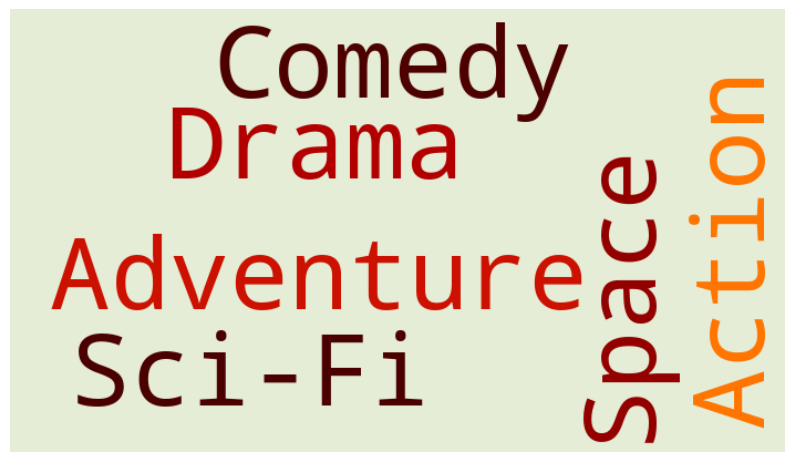

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [71]:
x = getAnimeFrame(1, anime_df)
getFavGenre(x, plot=True)

In [72]:
anime_df["Genres"].loc[1]

'Action, Drama, Mystery, Sci-Fi, Space'

In [73]:
tot_genre_freq = defaultdict(int)
genres_list = set()

for gl in anime_df["Genres"]:
    if isinstance(gl, str):
        g_list = [g for g in gl.split(',')]
        # print(g_list)
        for g in g_list:
            tot_genre_freq[g]+=1

print(tot_genre_freq)
print(len(tot_genre_freq))


defaultdict(<class 'int'>, {'Action': 3888, ' Military': 471, ' Adventure': 1477, ' Comedy': 2909, ' Drama': 1819, ' Magic': 973, ' Fantasy': 2767, ' Shounen': 1981, ' Mystery': 533, ' Super Power': 622, 'Thriller': 3, ' Sci-Fi': 2048, ' Historical': 883, ' Parody': 585, ' Samurai': 193, 'Military': 105, ' Space': 461, 'Drama': 800, ' School': 1593, ' Game': 203, ' Seinen': 820, ' Slice of Life': 944, 'Romance': 148, ' Supernatural': 1418, 'Slice of Life': 970, ' Romance': 1751, 'Mystery': 194, ' Vampire': 133, ' Mecha': 1017, 'Comedy': 3120, ' Sports': 543, 'Adventure': 1480, ' Josei': 94, ' Horror': 379, ' Police': 234, ' Psychological': 297, ' Thriller': 128, ' Music': 791, 'Sci-Fi': 535, ' Martial Arts': 416, ' Demons': 430, 'Supernatural': 61, ' Shoujo': 680, 'Fantasy': 518, 'Psychological': 48, 'Game': 183, ' Dementia': 130, 'Dementia': 382, 'Harem': 146, ' Ecchi': 637, 'Music': 1453, 'Demons': 71, 'Vampire': 3, 'Sports': 170, 'Kids': 1081, ' Shounen Ai': 98, ' Cars': 71, 'Ecchi'

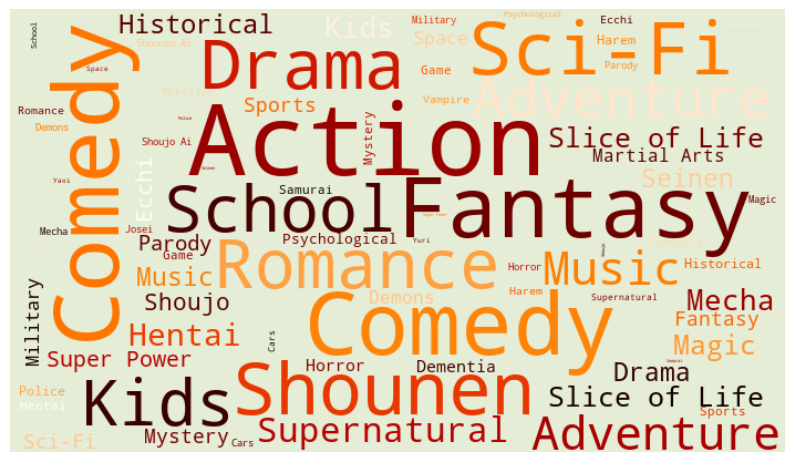

In [74]:
show_wordcloud(tot_genre_freq)

In [75]:
rating_df["user_id"].value_counts()

user_id
11100    14429
16869     8943
10255     8403
4773      5735
6852      5406
         ...  
5765       300
3445       300
11958      300
8046       300
11550      300
Name: count, Length: 7013, dtype: int64

In [76]:
anime_df.sample()

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
5543,8840,Night Raid 1931:The Prophecy,6.33,"Action, Historical, Military, Super Power",1,Special,A-1 Pictures,2493,R - 17+ (violence & profanity),Aniplex,23 min.,3591


In [77]:
def get_user_preferences(user_id, rating_df, anime_df, top_percentile=10, plot=False):
    try:
        animes_watched_by_user = rating_df[rating_df.user_id == user_id]
        ratings_by_user = rating_df[rating_df.user_id == user_id]["rating"]
        user_rating_percentile = np.percentile(ratings_by_user, 100-top_percentile) 
        ## Finf top 100-top_percentile rated animes
        animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
        
        top_animes_rated_by_user = (
            animes_watched_by_user.sort_values(by=["rating"], ascending=False).anime_id.values.tolist()
        )
        top_anime_df = anime_df[anime_df["MAL_ID"].isin(top_animes_rated_by_user)]
        top_anime_df = top_anime_df[["eng_version", "Genres"]]

        if plot:
            getFavGenre(top_anime_df, plot)

        # print(top_animes_rated_by_user)
        # display(top_anime_df)
        return top_anime_df
    
    except Exception as e:
        print(f"error while finding user preferences {e}")

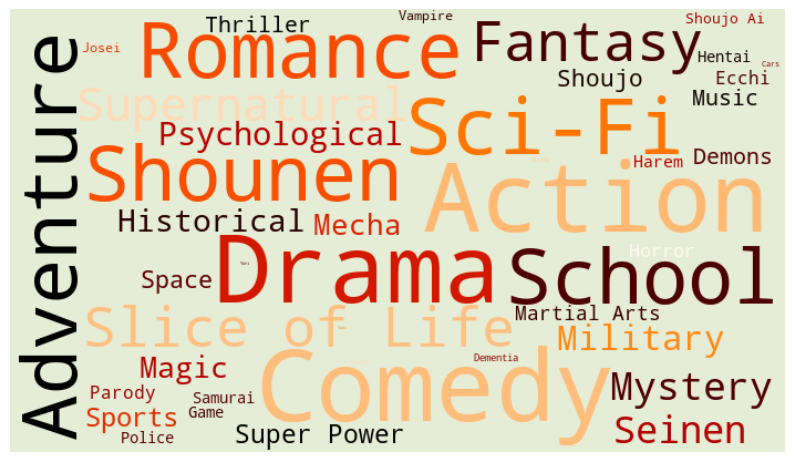

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2720,Midori,"Drama, Historical, Horror"
8255,Umigame to Shounen,"Drama, Historical"
15216,The Kind Devil,"Demons, Kids"
15378,Hua Jiang Hu Zhi Bu Liang Ren 3rd Season,"Historical, Drama, Romance, Martial Arts, Fantasy"


In [78]:
get_user_preferences(4773, rating_df, anime_df, plot=True)

In [79]:
similar_users(4773, user_embeddings_norm, anime_df, rating_df, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, k=10)

,user_id,similarity_score
9,7418,0.305248
8,2913,0.303790
7,16999,0.295003
6,3314,0.288659
5,16176,0.287644
4,13963,0.285138
3,16770,0.276459
2,11186,0.275197
1,12338,0.270072
0,1907,0.266308


In [80]:
##### ACTUAL USER BASED REC SYS

def get_user_recommendations(similar_users, user_pref, anime_df, synopsis_df, rating_df,top_percentile=30, n=10):
    '''
    Get recommendations for a user based on similar users' preferences.

    similar_users: DataFrame of similar users with their user_id and similarity score
    user_pref: DataFrame of user's preferences (animes rated by the user) cols:{eng_version , Genres}
    anime_df: DataFrame containing anime information
    synopsis_df: DataFrame containing anime synopses
    rating_df: DataFrame containing user ratings for animes
    top_percentile: Percentile of ratings to consider for recommendations
    n: Number of recommendations to return
    '''
    recommended_animes = []
    anime_list = []

    try:
        for user_id in similar_users.user_id.values:
            # what does users simialar to me prefer
            pref_list = get_user_preferences(user_id, rating_df, anime_df, top_percentile=top_percentile)
            # print(f"pref list :{pref_list.shape} for user {user_id} before filtering")
            
            # Rec some animes which (I) the user has no rated/watched yet
            pref_list = pref_list[~pref_list['eng_version'].isin(user_pref.eng_version.values)]

            # print(f"pref list :{pref_list.shape} for user {user_id} after filtering")
            ### ISSUE: if te user(I) is experienced, this filetrring out almost empty pref list of my similar users

            if not pref_list.empty:
                anime_list.extend(pref_list.eng_version.values.tolist())

            # print(f"User {user_id} has rated {len(pref_list)} animes with top percentile {top_percentile}")

            if anime_list:
                sorted_list = pd.Series(anime_list).value_counts().head(n)
                # print(f"anime list count: {len(anime_list)}, sorted list shape: {sorted_list.shape}")
                # print(f'Sorted list:\n{sorted_list}')

                for anime_name in sorted_list.index:
                    n_user_pref = sorted_list.loc[anime_name]

                    frame = getAnimeFrame(anime_name, anime_df)
                    if frame.empty:
                        # print(f"Frame not found for {anime_name}")
                        continue

                    anime_id = frame.MAL_ID.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n_pref": n_user_pref,
                        "anime_name": anime_name,
                        "Genres": genre,
                        "Synopsis": synopsis
                    })
        return pd.DataFrame(recommended_animes).head(n)
    
    except Exception as e:
        print(f"Error {e} at find user recommendations")

        

In [81]:
print(rating_df.sample())

         user_id  anime_id    rating  watching_status  watched_episodes  \
1745040     9373     28755  0.600098                2                 1   

         encoded_userID  encoded_animeID  
1745040            3261             1371  


In [82]:
rating_df["user_id"].value_counts().sort_values(ascending=False).tail(10)

user_id
15290    300
7881     300
16956    300
12115    300
16485    300
992      300
18713    300
7758     300
1517     300
11550    300
Name: count, dtype: int64

#### This `get_user_recommendations` function is helpful for new users whereas not that good form exp users as they have already watched most of the prefeered anime list rated by their similar users.


In [83]:
TMP_USER_ID = 7881
similar_users_list = similar_users(TMP_USER_ID, user_embeddings_norm, anime_df, rating_df, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, k=10)
pref_list = get_user_preferences(TMP_USER_ID, rating_df, anime_df, top_percentile=100)

similar_users_list
pref_list

tmp = get_user_recommendations(similar_users_list, pref_list, anime_df, synopsis_df, rating_df, top_percentile=70)
tmp

,n_pref,anime_name,Genres,Synopsis
0,3,Digimon:The Movie,"Sci-Fi, Adventure, Comedy, Kids","2047 This movie takes place after the Adventure series ends. It begins when a new Digimon Egg is found on the internet, and manages to penetrate into almost every computer system in Japan. When the egg hatches, it's identified as a new kind of Digimon, a Virus-type. It sustains itself by eating data from various system, and starts wreaking havok in Japan. As it consumes more and more data, it continues to evolve. And Taichi and Koushiro decide it's time to stop it. They're off, sending Agumon and Tentomon through the internet to fight off this new enemy. But, with the Virus controlling systems like the American military, all too soon, this digital menace may become all too real. Calling in the help of Yamato and Takeru, they hope that they can stop what's already begun, and maybe save this world a second time. (Source: AniDB) Name: synopsis, dtype: object"
1,2,Time of Eve,"Sci-Fi, Slice of Life","2600 In future Japan, in a time when android housekeepers have become commonplace, society strictly abides by the Three Laws of Robotics, which all androids must follow. Under the influence of the Robot Ethics Committee, androids are treated the same way as lesser technology, such as household appliances. However, a minority with an adoration for androids exists, categorized as ""android-holics,"" and are shunned by the general public. Rikuo Sakisaka was raised to accept society's precept about androids, and is perfectly aware that they are not human. That is, until the day he discovers a strange message buried within the activity logs of his household android, Sammy. This leads him to Eve no Jikan, a cafe with only one rule that its patrons must adhere to: there must be no distinction made between humans and androids. Curiosity drives Rikuo to learn more about the shop, and he attempts to unearth the reason behind Sammy's peculiar behavior. Name: synopsis, dtype: object"
2,2,Doraemon,"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen","2095 Nobita Nobi is a normal fourth grade student. This all changes, however, when a blue robotic cat appears from his desk drawer. Calling himself Doraemon, this robot tells Nobita that his future descendants from the 22nd century live in poverty because of all the mistakes he made. Therefore, they have sent Doraemon to serve as a guide and mentor to Nobita, so that their future may change for the better. What Doraemon comes to learn, though, is that Nobita is the weakest and laziest student in the whole school. To assist in his quest, Doraemon has a four-dimensional pocket with him, in which he keeps various machines and gadgets from the future. Unfortunately, these often result in even more trouble for Nobita. Will Doraemon really be able to achieve his mission of changing Nobita, or will he remain as he is? Name: synopsis, dtype: object"
3,1,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","3446 ""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant

---

<h1 style="text-align: center;color:#9efbd9; word-spacing: 20px;">HYBRID RECOMMENDATION SYS</h1>

In [ ]:
def hybrid_rec_sys(user_id, anime_df, rating_df,  user_embeddings_norm, anime_embeddings_norm, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping, top_percentile=30, user_wts=0.5 , content_wts=0.5, num_rec2return=10, num_similar_animes2rec=10, final_num2_rec=10):

    ## USER RECOMMENDATIONS
    similar_users_list = similar_users(user_id, user_embeddings_norm, anime_df, rating_df,userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping)
    user_prefs = get_user_preferences(user_id, rating_df, anime_df, top_percentile)
    user_recommendations = get_user_recommendations(similar_users_list, user_prefs, anime_df, synopsis_df, rating_df, top_percentile, n=num_rec2return)
    user_recommendations_anime_list = user_recommendations.anime_name.values

    ## CONTENT REC 
    content_recommended_anime_list = []
    for anime in user_recommendations_anime_list:
        simi_animes = getSimilarAnimes(anime, anime_embeddings_norm, anime_df, synopsis_df, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping, k=num_similar_animes2rec).name.values.tolist()
        
        if simi_animes is not None and not len(simi_animes)==0:
            content_recommended_anime_list.extend(simi_animes)

    ### WEIGHTED COMB of both
    combined_scores = {}

    for anime in user_recommendations_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0.0) + user_wts
        
    for anime in content_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0.0) + content_wts

    sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)    
    return [anime for anime, score in sorted_animes[:final_num2_rec]]

        


In [85]:
TMP_USER_ID=15597

hybrid_rec_sys(TMP_USER_ID, anime_df, rating_df, user_embeddings_norm, anime_embeddings_norm, userId_2_encodedUserId_mapping, encodedUserId_2_userId_mapping, animeId_2_encodedAnimeId_mapping, encodedAnimeId_2_animeId_mapping, top_percentile=30, user_wts=2.1 , content_wts=4.2, num_rec2return=10, num_similar_animes2rec=10)

["Seven Senses of the Re'Union",
 'Karo & Piyobupt:Imagination',
 'Yuri!!! On ICE',
 'Minami-ke Tadaima',
 'Fullmetal Alchemist:The Movie - Conqueror of Shamballa',
 'Pom Poko',
 'Fantastic Detective Labyrinth',
 'Sexy Fighter Manami',
 'Genmukan:The Sin of Desire & Shame',
 'Taimanin Asagi']

In [91]:
anime_df.sample(10)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Studios,Completed,Rating,Producers,Duration,Members
12320,34240,Shelter,8.34,"Sci-Fi, Music",1,Music,A-1 Pictures,234951,G - All Ages,Half H.P Studio,6 min.,265646
11429,32606,Onigiri,5.35,"Comedy, Supernatural, Fantasy",13,TV,Pierrot Plus,10254,PG-13 - Teens 13 or older,"Being, Zack Promotion, Bushiroad Music",4 min. per ep.,25939
12629,34813,Recommend! Godzilland,NaN,"Comedy, Kids",4,OVA,NaN,108,PG - Children,Gakken,25 min. per ep.,290
1265,1396,Future GPX Cyber Formula: Early Days Renewal,6.43,"Drama, Sci-Fi, Shounen, Sports",2,OVA,Sunrise,203,PG-13 - Teens 13 or older,NaN,58 min. per ep.,569
5678,9241,Super Robot Wars OG:The Inspector,7.25,"Action, Mecha, Sci-Fi, Space",26,TV,Asahi Production,3595,PG-13 - Teens 13 or older,Sotsu,23 min. per ep.,8114
347,371,Cardcaptor Sakura The Movie,7.64,"Comedy, Drama, Magic, Fantasy, Shoujo",1,Movie,Madhouse,72799,PG - Children,"Bandai Visual, Shochiku, Shelty",1 hr. 21 min.,83246
10148,29768,Fantastic Cell,4.82,Dementia,1,Movie,NaN,482,G - All Ages,Mirai Film,6 min.,616
1394,1536,Buso Renkin,7.35,"Action, Fantasy, Supernatural, Comedy, School, Shounen",26,TV,Xebec,92215,PG-13 - Teens 13 or older,"Geneon Universal Entertainment, Yomiko Advertising, Shueisha, Imagine",24 min. per ep.,152465
16310,40700,Shikijou Kyoudan,6.74,Hentai,2,OVA,NaN,2226,Rx - Hentai,NaN,16 min. per ep.,3495
1385,1527,Pokemon:The Mastermind of Mirage Pokemon,6.48,"Adventure, Comedy, Fantasy, Kids",1,ONA,OLM,20533,PG - Children,"VIZ Media, Studio Jack",42 min.,23837


In [94]:
# for i in range(205):
i=347
print(f'Anime name : {get_anime_name(i)} for {i}')

error while retriving anime name
Anime name : None for 347


In [133]:
import joblib

tmp_animeid2encodedAnimeId_mapping = joblib.load("../artifacts/processed/animeId_2_encodedAnimeId_mapping.pkl")

print(f"{tmp_animeid2encodedAnimeId_mapping
         }")

{67: 0, 6702: 1, 242: 2, 4898: 3, 21: 4, 24: 5, 2104: 6, 4722: 7, 6098: 8, 3125: 9, 481: 10, 68: 11, 1689: 12, 2913: 13, 1250: 14, 356: 15, 121: 16, 430: 17, 1829: 18, 1571: 19, 578: 20, 431: 21, 2762: 22, 570: 23, 3418: 24, 3010: 25, 1004: 26, 433: 27, 600: 28, 2034: 29, 164: 30, 4086: 31, 457: 32, 20: 33, 1074: 34, 761: 35, 2248: 36, 597: 37, 1047: 38, 459: 39, 466: 40, 2543: 41, 419: 42, 199: 43, 169: 44, 2547: 45, 174: 46, 448: 47, 2236: 48, 415: 49, 1894: 50, 269: 51, 235: 52, 71: 53, 245: 54, 134: 55, 1887: 56, 3457: 57, 1535: 58, 1726: 59, 228: 60, 1735: 61, 1482: 62, 5114: 63, 256: 64, 19: 65, 877: 66, 272: 67, 853: 68, 177: 69, 1985: 70, 202: 71, 2006: 72, 482: 73, 37403: 74, 9989: 75, 24833: 76, 7674: 77, 34572: 78, 34566: 79, 2167: 80, 40852: 81, 10087: 82, 38680: 83, 40052: 84, 40748: 85, 1604: 86, 20507: 87, 38483: 88, 26243: 89, 42203: 90, 40028: 91, 39551: 92, 39617: 93, 3972: 94, 22199: 95, 6547: 96, 9919: 97, 5081: 98, 31043: 99, 31964: 100, 33486: 101, 36456: 102, 384